In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import numpy as np

import uproot
import awkward as ak
from coffea import nanoevents

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup

from HHbbVV.processors.utils import pad_val

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 24})

Look at single SM VBF HH signal NanoAOD file

In [2]:
events = nanoevents.NanoEventsFactory.from_root(
    # "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V__C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_1_C3_1/220808_150149/0000/nano_mc2018_1-1.root",
    "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
    # "/uscms/home/rkansal/nobackup/vbf.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
b_PDGID = 5
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

/usr/local/Caskroom/mambaforge/base/envs/bbVV/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1937 branches) at 0x7fc038778880>, taking first instance
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/bbVV/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1937 branches) at 0x7fc038778880>, taking first instance
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/bbVV/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1937 branches) at 0x7fc038778880>, taking first instance
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/bbVV/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (19

Get generator-level Higgs and Vs

In [3]:
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

higgs_children = higgs.children

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.any(is_bb, axis=2)]
HVV = higgs[ak.any(is_VV, axis=2)]

# make sure we're only getting one Higgs
Hbb = ak.pad_none(Hbb, 1, axis=1)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1)[:, 0]

vs = events.GenPart[((abs(events.GenPart.pdgId) == 24)) * events.GenPart.hasFlags(GEN_FLAGS)]

# vbf output quarks are always at index 4, 5
gen_quarks = events.GenPart[events.GenPart.hasFlags(["isHardProcess"])][:, 4:6]

Check gen-level plots

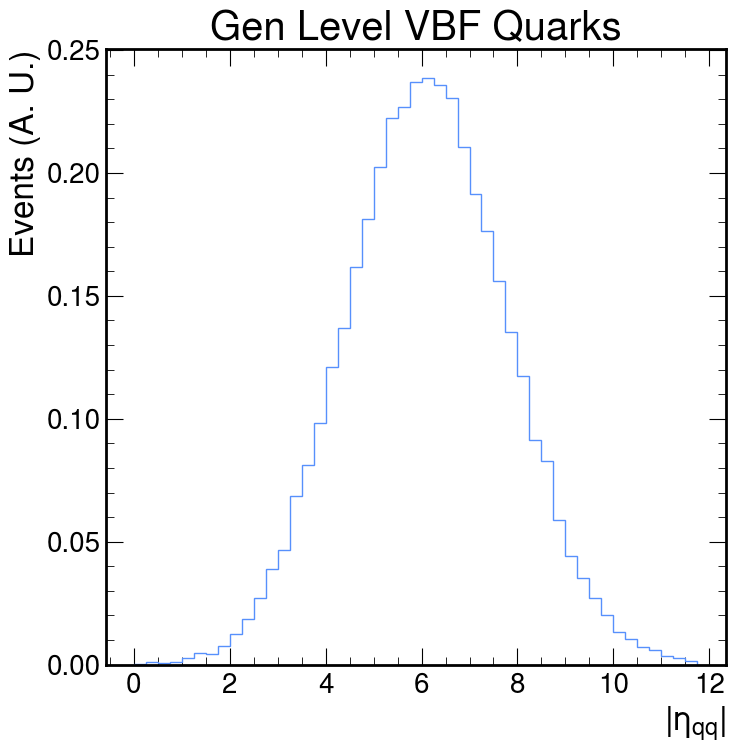

In [4]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(
    np.abs(gen_quarks.eta[:, 0] - gen_quarks.eta[:, 1]),
    np.arange(0, 12, 0.25),
    histtype="step",
    density=True,
)
plt.xlabel(r"$|\eta_{qq}|$")
plt.ylabel("Events (A. U.)")
plt.show()

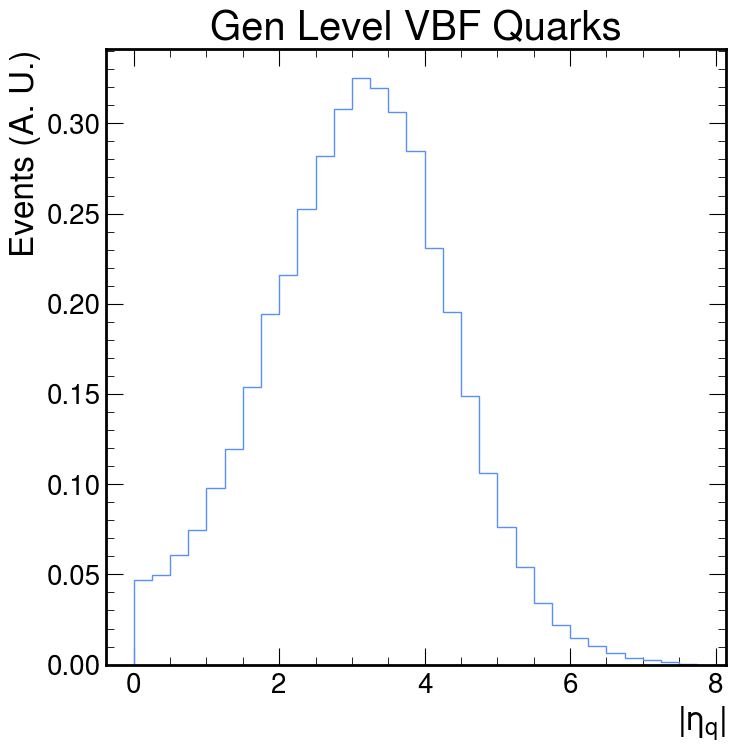

In [5]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(np.abs(gen_quarks.eta)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$|\eta_{q}|$")
plt.ylabel("Events (A. U.)")
plt.show()

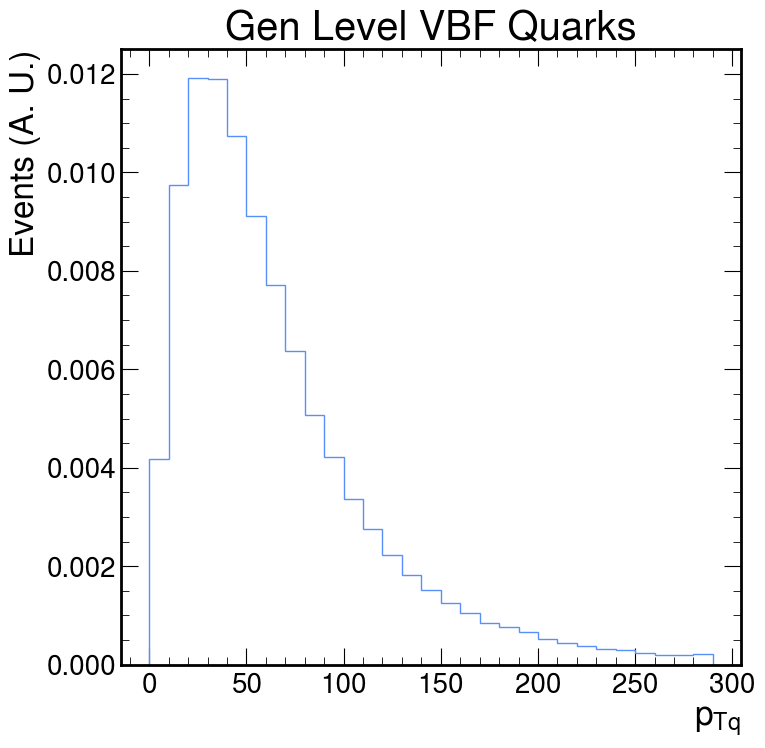

In [6]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(gen_quarks.pt), np.arange(0, 300, 10), histtype="step", density=True)
plt.xlabel(r"$p_{Tq}$")
plt.ylabel("Events (A. U.)")
plt.show()

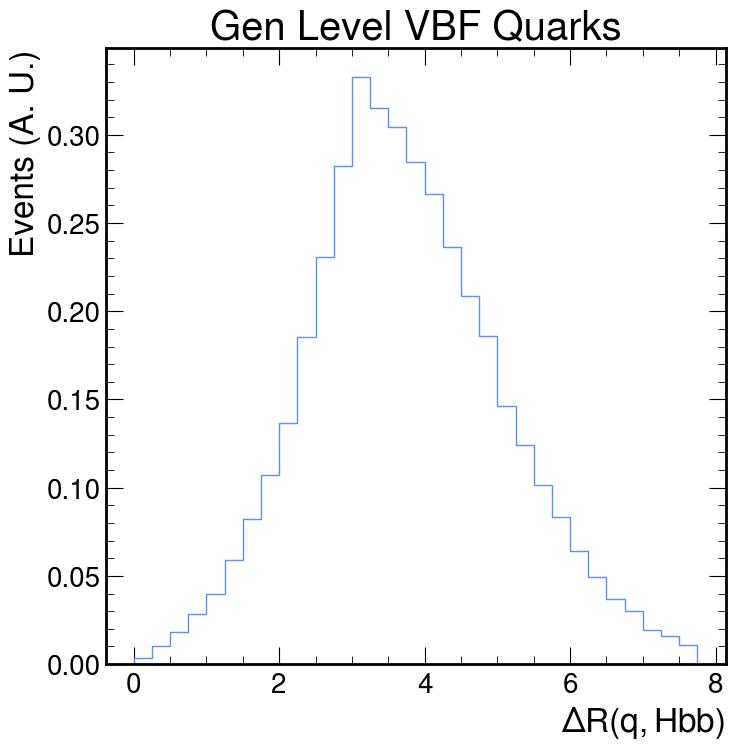

In [7]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(Hbb.delta_r(gen_quarks)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, Hbb)$")
plt.ylabel("Events (A. U.)")
plt.show()

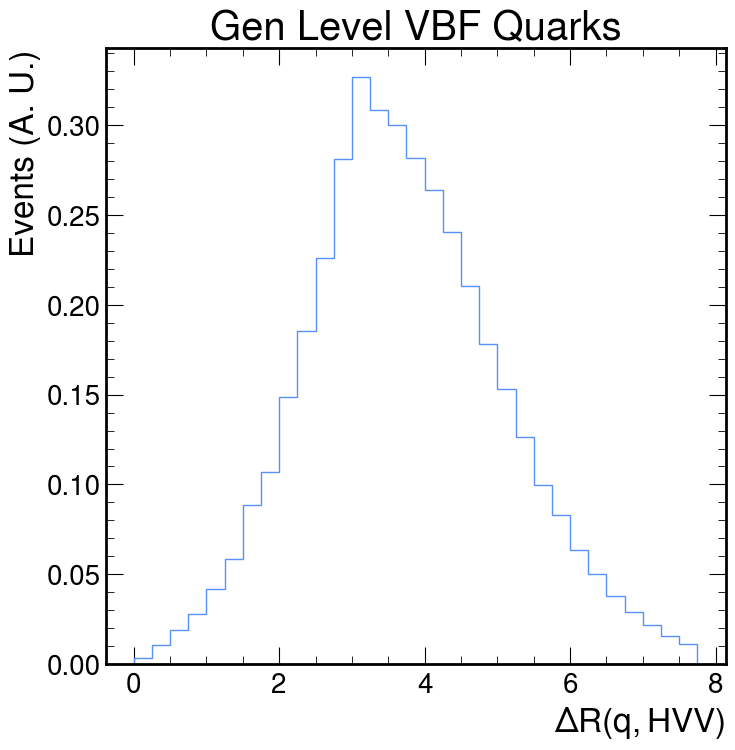

In [8]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(HVV.delta_r(gen_quarks)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, HVV)$")
plt.ylabel("Events (A. U.)")
plt.show()

Matching efficiency calculation

In [9]:
def matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4):
    drs = ak.pad_none(vbf_jets, 2, axis=1)[:, :2].metric_table(gen_quarks)
    matched = drs < matching_dr
    # TODO: add overlap removal?
    print(np.mean(np.all(np.any(matched, axis=2), axis=1)))

Reproduce AK4 jet selections from skimmer

In [10]:
# ak8 jet preselection
preselection = {  # noqa: RUF012
    "pt": 300.0,
    "eta": 2.4,
    "VVmsd": 50,
    # "VVparticleNet_mass": [50, 250],
    # "bbparticleNet_mass": [92.5, 162.5],
    "bbparticleNet_mass": 50,
    "VVparticleNet_mass": 50,
    "bbFatJetParticleNetMD_Txbb": 0.8,
    "jetId": 2,  # tight ID bit
    "DijetMass": 800,  # TODO
    # "nGoodElectrons": 0,
}

num_jets = 2

In [11]:
fatjets = events.FatJet

fatjets = ak.pad_none(
    fatjets[(fatjets.pt > 300) * (fatjets.isTight) * (np.abs(fatjets.eta) <= 2.4)], 2, axis=1
)

# particlenet xbb vs qcd

txbb = pad_val(
    fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
    num_jets,
    axis=1,
)

# bb VV assignment

bb_mask = txbb[:, 0] >= txbb[:, 1]
bb_mask = np.stack((bb_mask, ~bb_mask)).T

Leptons

In [12]:
electrons = events.Electron
electrons = electrons[(electrons.pt > 5) & (electrons.cutBased >= electrons.LOOSE)]

muons = events.Muon
muons = muons[(muons.pt > 7) & (muons.looseId)]

In [13]:
ak4_jet_selection = {  # noqa: RUF012
    "pt": 15,
    "eta_min": 0,
    "eta_max": 4.9,
    "jetId": "tight",
    "puId": "medium",
    "dR_fatjetbb": 1.15,
    "dR_fatjetVV": 0.95,
}

jets = events.Jet

# dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
# https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
# (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
vbf_jet_mask = (
    jets.isTight
    & (jets.pt > ak4_jet_selection["pt"])
    & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
    & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
    # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
    & ((jets.pt > 50) | ((jets.puId & 2) == 2))
    & (
        ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
        > ak4_jet_selection["dR_fatjetbb"]
    )
    & (
        ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
        > ak4_jet_selection["dR_fatjetVV"]
    )
    & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
)

vbf_jets = jets[vbf_jet_mask]

In [14]:
sel = ak.fill_none(
    (
        (txbb[bb_mask] > 0.97)
        * (fatjets.particleNet_H4qvsQCD[~bb_mask] > 0.6)
        * (fatjets.pt[:, 0] > 500)
        * (fatjets.pt[:, 1] > 400)
        * (np.abs(fatjets[:, 0].delta_phi(fatjets[:, 1])) > 2.6)
        * (np.abs(fatjets[:, 0].eta - fatjets[:, 1].eta) < 2.0)
    ),
    False,
)

matching_efficiency(gen_quarks[sel], vbf_jets[sel])

0.3569364161849711


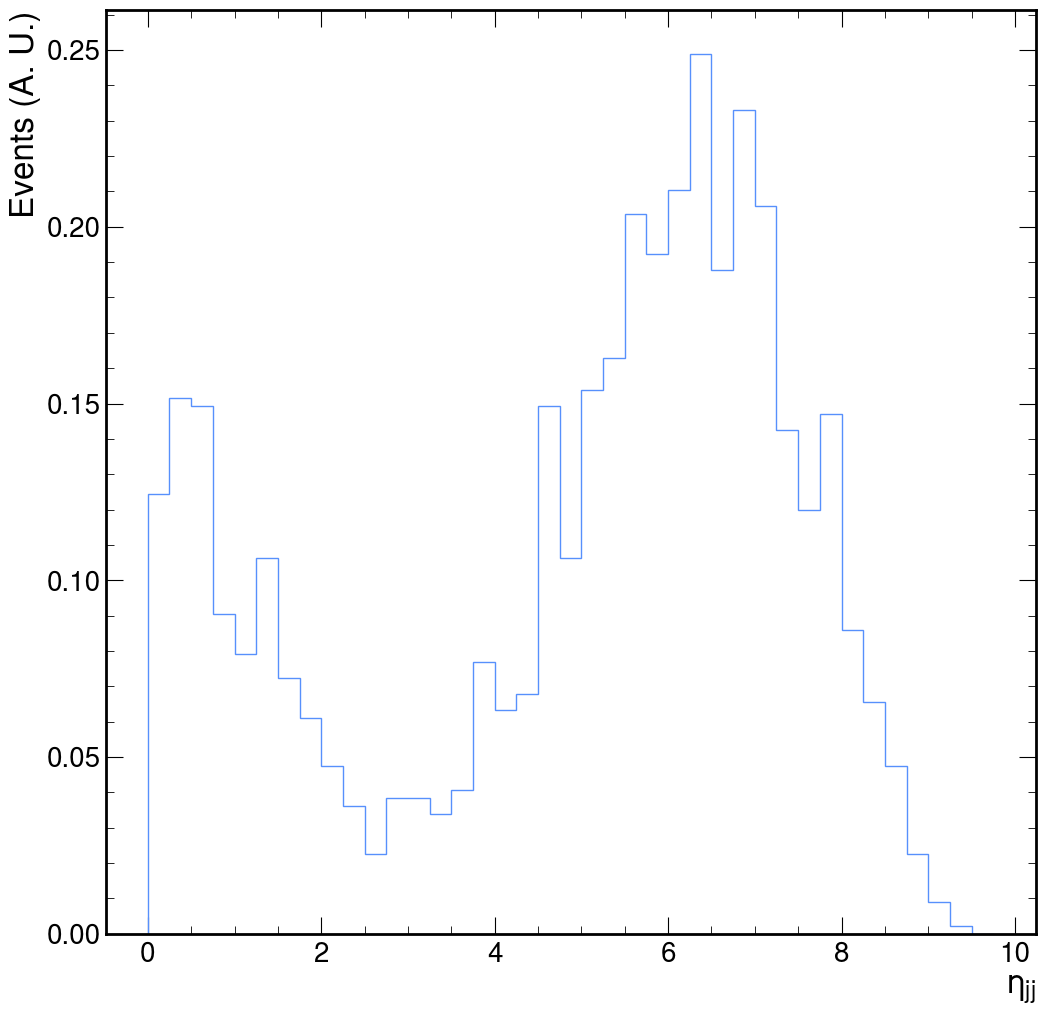

In [15]:
etas = pad_val(
    vbf_jets[ak.fill_none(sel & (ak.count(vbf_jets.pt, axis=1) >= 2), False)].eta, 2, axis=1
)

plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
plt.hist(np.abs(etas[:, 0] - etas[:, 1]), np.arange(0, 10, 0.25), histtype="step", density=True)
plt.xlabel(r"$\eta_{jj}$")
plt.ylabel("Events (A. U.)")
plt.show()

Checking how many events have jets which match with the gen quarks

In [16]:
jets = events.Jet
np.mean(ak.all(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1))

0.5361212121212121

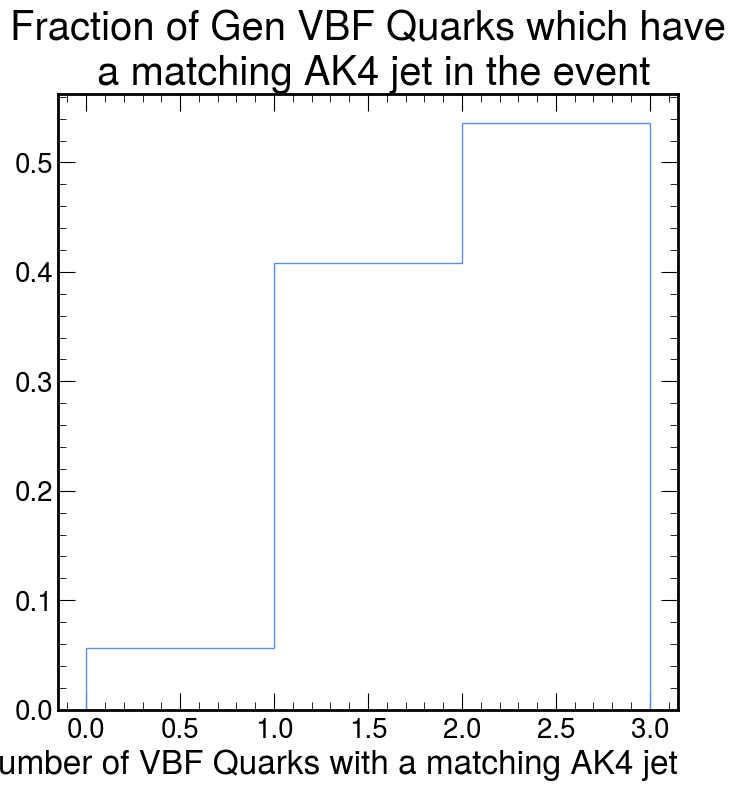

In [17]:
plt.figure(figsize=(8, 8))
plt.hist(
    ak.sum(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1),
    [0, 1, 2, 3],
    histtype="step",
    density=True,
)
plt.xlabel("Number of VBF Quarks with a matching AK4 jet")
plt.title("Fraction of Gen VBF Quarks which have\n a matching AK4 jet in the event")
plt.show()